# Hypothesis learning: when sGP meets RL

- Made by Maxim Ziatdinov (2022), https://scholar.google.com/citations?user=YnSdOoUAAAAJ
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!

This notebook demonstrates how to apply the hypothesis learning to  toy data. The hypothesis learning is based on the idea that in active learning, the correct model of the system’s behavior leads to a faster decrease in the overall Bayesian uncertainty about the system under study. In the hypothesis learning setup, probabilistic models of the possible system’s behaviors (hypotheses) are wrapped into structured GPs, and a basic reinforcement learning policy is used to select a correct model from several competing hypotheses.


First of all, what are hypotheses and why do we need them? This question is on one hand is somewhat philosophical and deeply foundational to how science works. At the same time, it has rather immediate implications in active learning. 

First of all, it is important to recognize that science is a process of exploring the unknown. Based on our current knowledge, we formulate the hypotehsis about how the world **may** work. It can be hypothesis about what the numerical values of the parameters are. It can be a hypothesis about which of the possible models of system behavior is correct. However, in all cases we make an **extrapolation** about what the system behavior might be, and we try to formulate it as a fninite number of alternatives. With the hypothesis in hand, the purpose of the experiment is twofold. One is to falsify the hypothesis. The second is to keep an eye on serendipitous discoveries.

Now, why do we need hypothesis? Very simple - our experimental budgets are usually very limited. Which means that we need to formulate the questions in such a way that they can be answered in a small number of attempts. For example, classical data driven reinforcement learning is almost useless in experiment - it takes to much data to learn what are right policies. Hypotheses allow us to do it much faster (for Mario - should I step on suspicious moving brown muchroom? Should I pick the gold coin?)

The hypothesis learning is a combination of the basic reward concept from RL and Bayesian probabilistic learning, where we introduce reward to the model that can learn faster. If you are interested in the real-world examples, have a look at our recent work applying it for:
- Combinatorial materials libraries: https://arxiv.org/abs/2112.06649 
- Fully autonomous Scanning Probe Microscopy: https://arxiv.org/abs/2202.01089


In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 12.6 MB/s eta 0:00:00


In [ ]:
from typing import Union, Dict, Type

import gpax

import jax.numpy as jnp
import jax.random as jra
import numpy as onp
import numpyro
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

Let's define several helper functions for plotting and organizing data:

In [ ]:
def get_training_data(X, Y, num_seed_points=2, rng_seed=42, **kwargs):
    onp.random.seed(rng_seed)
    indices = jnp.arange(len(X))
    idx = kwargs.get("list_of_indices")
    if idx is not None:
        idx = onp.array(idx)
    else:
        idx = onp.random.randint(0, len(X), num_seed_points)
    idx = onp.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, idx)
    y_test = jnp.delete(Y, idx)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test
    

def plot_results(X_measured, y_measured, X_unmeasured, y_pred, y_sampled, obj, model_idx, rewards, **kwargs):
    X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X_measured, y_measured, marker='x', s=100, c='k', label="Measured points", zorder=1)
    ax1.plot(X, y_pred, c='red', label='Model reconstruction', zorder=0)
    ax1.fill_between(X, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                     color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    ax1.set_xlabel("$x$", fontsize=18)
    ax1.set_ylabel("$y$", fontsize=18)
    ax2.plot(X_unmeasured, obj, c='k')
    ax2.vlines(X_unmeasured[obj.argmax()], obj.min(), obj.max(), linestyles='dashed', label= "Next point")
    ax2.set_xlabel("$x$", fontsize=18)
    ax2.set_ylabel("Acquisition function", fontsize=18)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    step = kwargs.get("e", 0)
    plt.suptitle("Step: {},  Sampled Model: {}, Rewards: {}".format(
        step+1, model_idx, onp.around(rewards, 3).tolist()), fontsize=24)
    fig.savefig("./{}.png".format(step))
    plt.show() 
    

def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()
    

def plot_final_result(X, y, X_test, y_pred, y_sampled, seed_points):
    plt.figure(dpi=100)
    plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
                cmap='viridis', label="Sampled points", zorder=2)
    cbar = plt.colorbar(label="Exploration step")
    cbar_ticks = jnp.arange(2, len(X[seed_points:]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
                c='k', label="Seed points", zorder=1)
    plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=1)
    plt.plot(X_test, truefunc, c='k', label="Ground truth", zorder=0)
    plt.fill_between(X_test, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                            color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel("$y$", fontsize=12)
    plt.legend(fontsize=9, loc='upper left')
    #plt.ylim(1.8, 6.6)
    plt.show()

Secondly, let's generate some data. As an example, let's assume that we are interested in the active learning of phase diagram that has a transition between different phases. The phase transition manifests in discontinuity of a measurable system’s property, such as heat capacity. However, we usually do not know where a phase transition occurs precisely, nor are we aware of the exact behavior of the property of interest in different phases. 

Text(0, 0.5, '$y$')

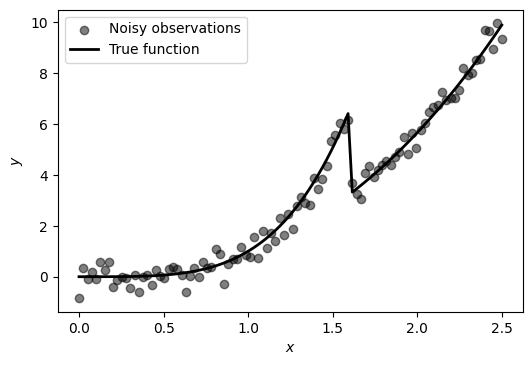

In [ ]:
def function_(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


X = jnp.linspace(0.0, 2.5, 100)
params = {"t": 1.6, "beta1": 4, "beta2": 2.5}

truefunc = function_(X, params)
Y = truefunc + 0.33 * jra.normal(jra.PRNGKey(0), shape=truefunc.shape)

_, ax = plt.subplots(dpi=100)            
ax.scatter(X, Y, alpha=0.5, c='k', label="Noisy observations")
ax.plot(X, truefunc, lw=2, c='k', label="True function")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

We note that using a standard Gaussian process-based active learning is not an optimal choice in such a case as simple GP struggles around the discontinuity point. 

Structured GP does not have this problem. However, sGP requires knowledge of physical model of system behavior - and if we know the right model its the best way to proceed. But what if several models are possible, and we do not know which one is correct? Meaning that we have several competing hypotheses?

Well, thats' when hypotehsis learnign comes into paly. Let's define several possible models of system's behavior as deterministic functions:

In [ ]:
def piecewise1(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta"], lambda x: params["c"]*x])
    
def piecewise2(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: params["b"]*x, lambda x: params["c"]*x])
    
def piecewise3(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])

Now, let's put priors over parameters of each model to make them probabilistic. As we discussed, priors reflect what we know about the system. Narrow priors mean that we are certain baout parameter values, and broad (weakly informative) priors mean that we do not know much. Also, we can very naturally define the hard limits (non-negativety, etc) via priors by choosing uniform or half-normal distributions:

In [ ]:
def piecewise1_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta = numpyro.sample("beta", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta": beta, "c": c}

def piecewise2_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    b = numpyro.sample("b", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "b": b, "c": c}

def piecewise3_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(3, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}

As before, we need to specify custom priors over GP kernel:

In [ ]:
 def gp_kernel_prior() -> Dict[str, jnp.ndarray]:
     length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
     scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
     return {"k_length": length, "k_scale": scale}

noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.1))

We introduce the helper functions for running the hypothesis learning:

In [ ]:
def get_best_model(record):
    return record[:,1].argmax()

def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    if jnp.nanmedian(obj) < obj_history[-1]:  # one can use integral uncertainty instead of median
        r = 1
    else:
        r = -1
    return r

def step(model, model_prior, X_train, y_train, X_new=None, num_restarts=1, **kwargs):
    """Compute model posterior and use it to derive acqusition function"""
    acq_fn = gpax.acquisition.UE
    verbose = kwargs.get("print_summary", True)
    sgr = numpyro.diagnostics.split_gelman_rubin
    for i in range(num_restarts):
        rng_key, rng_key_predict = gpax.utils.get_keys(i)
        # Get/update model posterior. In the paper, we used
        # num_samples = num_warmup = 5000 but that takes some time
        gp_model = gpax.ExactGP(
            1, 'Matern', kernel_prior=gp_kernel_prior,
            mean_fn=model, mean_fn_prior=model_prior, noise_prior=noise_prior)
        gp_model.fit(
            rng_key, X_train, y_train, num_warmup=2000,
            num_samples=2000, num_chains=1, print_summary=verbose)
        rhats = [sgr(v).item() for v in gp_model.get_samples(1).values()]
        if max(rhats) < 1.1:
            break 
    # Compute acquisition function
    obj = 0
    if X_new is not None:
        obj = acq_fn(rng_key_predict, gp_model, X_new)
    return obj, gp_model

def update_datapoints(next_point_idx, train, test):
    """Update "measured" dummy data points"""
    X_train, y_train, indices_train = train
    X_test, y_test, indices_test = test
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, y_test[next_point_idx])
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point_idx)
    indices_test = jnp.delete(indices_test, next_point_idx)
    return (X_train, y_train, indices_train), (X_test, y_test, indices_test)

Generate seed points:

In [ ]:
(X_train, y_train, X_test, y_test,
     indices_train, indices_test) = get_training_data(X, Y, list_of_indices=[0, 33, 66, 99])
num_seed_points = len(X_train)

Now, we can instantiate hypothesis learnign algorithm. Here, we will use the epsilon-greedy policy to choose betweem models. 

Warmup step 1/3


sample: 100%|██████████| 4000/4000 [00:28<00:00, 138.07it/s, 1023 steps of size 5.24e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.24      0.51      2.25      1.39      3.03     37.84      1.00
         c      3.67      0.37      3.69      3.10      4.22     31.22      1.07
  k_length      0.43      0.28      0.37      0.06      0.90     41.66      1.02
   k_scale      1.04      1.25      0.67      0.10      2.18     26.57      1.02
     noise      0.09      0.06      0.08      0.00      0.16     53.87      1.04
         t      1.75      0.31      1.83      1.49      2.00     16.72      1.06



sample: 100%|██████████| 4000/4000 [00:22<00:00, 178.94it/s, 1023 steps of size 6.95e-04. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.16      0.60      2.07      1.18      3.06     51.00      1.01
         c      3.62      0.45      3.67      2.86      4.38     20.06      1.14
  k_length      0.53      0.30      0.55      0.09      0.97     53.72      1.02
   k_scale      1.31      1.50      0.79      0.12      3.00     29.83      1.07
     noise      0.09      0.06      0.08      0.00      0.17    111.33      1.01
         t      1.70      0.36      1.80      1.08      2.00     18.06      1.14



sample: 100%|██████████| 4000/4000 [00:07<00:00, 538.55it/s, 7 steps of size 3.17e-01. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.85      1.01      2.83      1.18      4.43    966.40      1.00
     beta2      2.43      0.11      2.44      2.25      2.60    893.68      1.00
  k_length      0.45      0.28      0.43      0.00      0.85   1325.90      1.00
   k_scale      0.82      0.72      0.62      0.09      1.60   1077.78      1.00
     noise      0.08      0.06      0.07      0.00      0.16   1073.28      1.00
         t      1.15      0.40      1.14      0.50      1.68   1052.29      1.00

Warmup step 2/3


sample: 100%|██████████| 4000/4000 [00:23<00:00, 171.99it/s, 1023 steps of size 7.01e-03. acc. prob=0.75]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.87      0.94      2.79      1.62      4.81    544.32      1.00
         c      3.29      0.48      3.28      2.57      4.14    397.90      1.00
  k_length      0.19      0.16      0.16      0.00      0.39    583.58      1.00
   k_scale      2.09      1.46      1.68      0.37      4.03    561.38      1.00
     noise      0.09      0.06      0.07      0.00      0.18    480.39      1.00
         t      1.32      0.41      1.29      0.80      2.00    281.14      1.00



sample: 100%|██████████| 4000/4000 [00:28<00:00, 139.32it/s, 1023 steps of size 4.37e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.30      0.59      2.29      1.48      3.43     36.31      1.01
         c      3.46      0.48      3.51      2.66      4.20     10.28      1.15
  k_length      0.19      0.16      0.14      0.00      0.43     32.12      1.00
   k_scale      1.82      1.48      1.37      0.27      3.48     18.46      1.06
     noise      0.09      0.06      0.09      0.00      0.18     30.27      1.07
         t      1.54      0.47      1.75      0.74      2.00     13.25      1.05



sample: 100%|██████████| 4000/4000 [00:31<00:00, 126.79it/s, 1023 steps of size 5.27e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.44      0.77      3.65      2.12      4.50     12.78      1.10
     beta2      2.43      0.11      2.43      2.26      2.60     19.87      1.10
  k_length      0.31      0.28      0.21      0.00      0.78     20.28      1.11
   k_scale      1.03      0.91      0.78      0.08      2.03     25.11      1.04
     noise      0.09      0.06      0.09      0.00      0.17     33.35      1.08
         t      1.39      0.31      1.52      0.77      1.67      8.01      1.21

Warmup step 3/3


sample: 100%|██████████| 4000/4000 [00:33<00:00, 118.82it/s, 1023 steps of size 3.46e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.06      0.70      3.06      2.09      4.64     13.36      1.00
         c      3.50      0.47      3.55      2.77      4.26      4.69      1.42
  k_length      0.05      0.07      0.03      0.00      0.10     15.83      1.10
   k_scale      2.10      1.40      1.72      0.49      3.42     18.34      1.07
     noise      0.08      0.06      0.08      0.00      0.16      8.82      1.37
         t      1.60      0.40      1.74      0.84      1.98      5.44      1.38



sample: 100%|██████████| 4000/4000 [00:25<00:00, 156.40it/s, 1023 steps of size 6.58e-05. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      4.29      0.27      4.30      3.88      4.76      5.39      1.40
         c      2.55      0.33      2.54      2.03      2.99      2.89      2.55
  k_length      0.46      0.18      0.45      0.14      0.75      7.27      1.04
   k_scale      2.31      0.35      2.23      1.80      2.86      6.68      1.03
     noise      0.13      0.07      0.12      0.03      0.23      3.20      1.76
         t      1.63      0.02      1.63      1.60      1.67    152.89      1.00



sample: 100%|██████████| 4000/4000 [00:31<00:00, 127.73it/s, 1023 steps of size 7.95e-04. acc. prob=0.78]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.99      0.14      4.00      3.75      4.21    142.18      1.00
     beta2      2.44      0.10      2.44      2.27      2.59     62.52      1.02
  k_length      0.50      0.28      0.49      0.09      0.99     49.40      1.00
   k_scale      0.76      0.62      0.58      0.06      1.47     89.72      1.00
     noise      0.07      0.06      0.06      0.00      0.15     56.38      1.01
         t      1.63      0.02      1.63      1.59      1.66    448.56      1.00

Exploration step 4/15
Using model 1


sample: 100%|██████████| 4000/4000 [00:38<00:00, 103.26it/s, 1023 steps of size 6.53e-04. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      4.31      0.33      4.35      3.82      4.85      8.35      1.20
         c      3.07      0.37      3.06      2.40      3.62      5.40      1.45
  k_length      0.28      0.18      0.25      0.02      0.56     10.43      1.00
   k_scale      1.92      0.86      1.76      0.70      3.24      6.60      1.26
     noise      0.08      0.05      0.08      0.01      0.16      4.45      1.79
         t      1.61      0.02      1.62      1.59      1.64     66.24      1.01



sample: 100%|██████████| 4000/4000 [00:40<00:00, 99.62it/s, 1023 steps of size 2.54e-03. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      4.05      0.60      4.25      3.00      4.81     28.61      1.14
         c      3.07      0.49      3.06      2.30      3.88    108.74      1.05
  k_length      0.26      0.21      0.22      0.00      0.57     29.81      1.06
   k_scale      2.19      1.41      1.78      0.50      4.02    169.37      1.00
     noise      0.08      0.06      0.07      0.00      0.16    289.64      1.00
         t      1.60      0.07      1.61      1.43      1.65     10.02      1.03



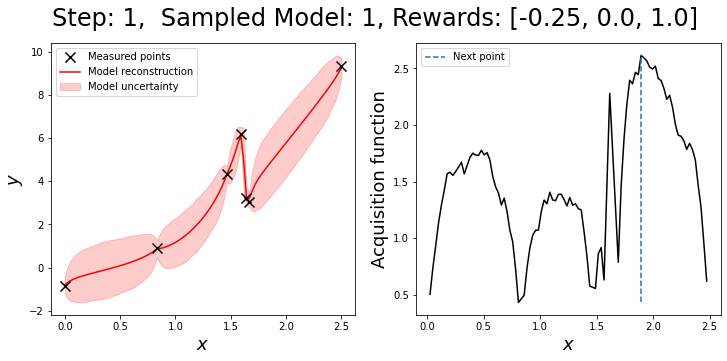

Exploration step 5/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:22<00:00, 175.99it/s, 63 steps of size 2.01e-02. acc. prob=0.75] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.94      0.15      3.95      3.69      4.17    453.46      1.00
     beta2      2.42      0.10      2.43      2.27      2.58    572.04      1.00
  k_length      0.53      0.26      0.54      0.11      0.96    409.41      1.00
   k_scale      0.68      0.62      0.49      0.05      1.41    498.93      1.00
     noise      0.08      0.05      0.07      0.01      0.16    717.48      1.00
         t      1.62      0.01      1.62      1.60      1.64    500.01      1.00



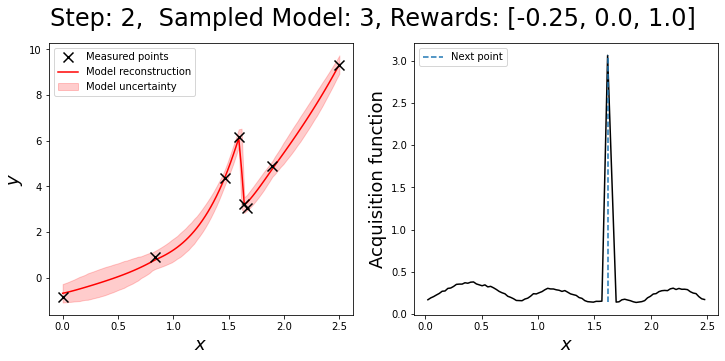

Exploration step 6/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:51<00:00, 77.99it/s, 1023 steps of size 1.08e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.94      0.97      2.81      1.43      4.65     20.46      1.02
         c      3.03      0.39      3.03      2.38      3.68     91.01      1.02
  k_length      0.13      0.24      0.04      0.00      0.59     14.77      1.02
   k_scale      2.42      1.43      2.02      0.65      4.20    161.69      1.00
     noise      0.10      0.07      0.09      0.00      0.20     66.57      1.03
         t      1.48      0.20      1.52      1.17      1.84      8.21      1.15



sample: 100%|██████████| 4000/4000 [00:47<00:00, 84.73it/s, 1023 steps of size 2.10e-05. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      4.44      0.09      4.45      4.27      4.58     10.09      1.00
         c      3.37      0.10      3.34      3.23      3.52      3.60      1.41
  k_length      0.06      0.01      0.06      0.04      0.08      7.00      1.47
   k_scale      2.19      0.13      2.20      1.94      2.37      3.15      1.87
     noise      0.09      0.01      0.09      0.08      0.11      3.48      1.68
         t      1.60      0.01      1.60      1.59      1.62     44.63      1.01



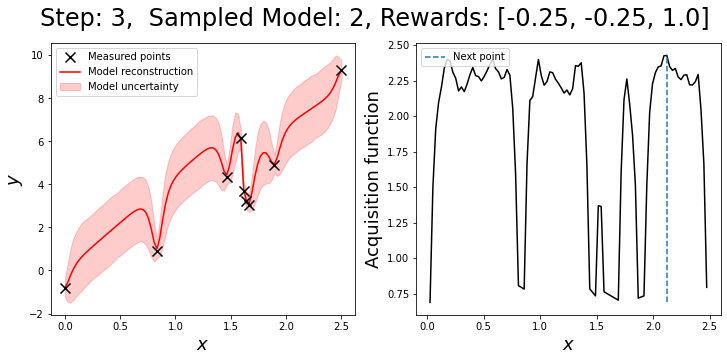

Exploration step 7/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:52<00:00, 75.56it/s, 1023 steps of size 5.12e-03. acc. prob=0.72]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.83      0.17      3.84      3.57      4.10    512.67      1.00
     beta2      2.42      0.10      2.43      2.26      2.57    379.21      1.00
  k_length      0.52      0.30      0.54      0.00      0.90    424.71      1.00
   k_scale      0.65      0.59      0.47      0.05      1.35    603.84      1.00
     noise      0.11      0.05      0.10      0.02      0.18    545.16      1.00
         t      1.60      0.01      1.60      1.59      1.61    538.97      1.00



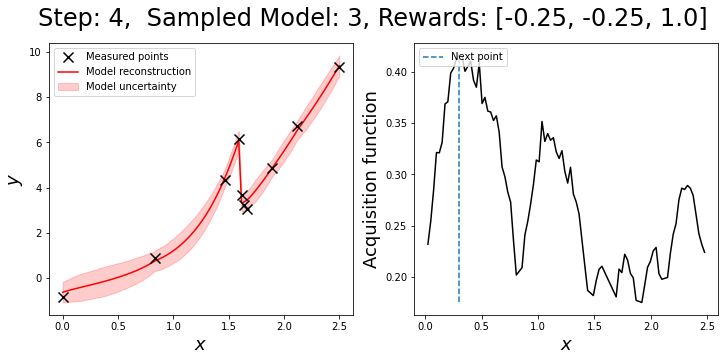

Exploration step 8/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:10<00:00, 56.37it/s, 1023 steps of size 2.39e-03. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.84      0.15      3.85      3.62      4.10    454.48      1.00
     beta2      2.43      0.09      2.44      2.29      2.56    311.62      1.00
  k_length      0.56      0.29      0.60      0.03      0.94    157.85      1.01
   k_scale      0.57      0.53      0.41      0.05      1.14    350.76      1.00
     noise      0.10      0.05      0.10      0.02      0.20    305.88      1.00
         t      1.60      0.01      1.60      1.59      1.61    370.34      1.00



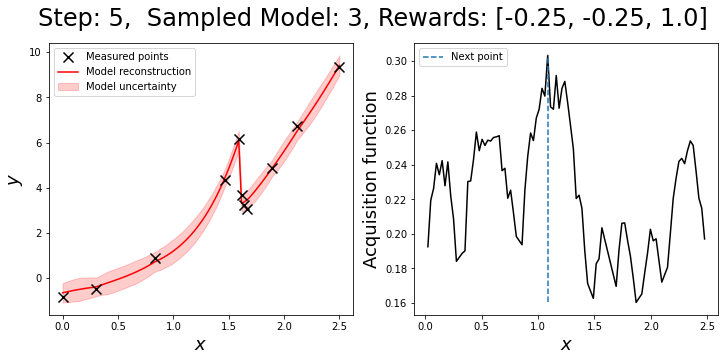

Exploration step 9/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:59<00:00, 67.44it/s, 1023 steps of size 1.07e-03. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.39      0.67      2.37      1.21      3.39    155.22      1.01
         c      3.14      0.35      3.11      2.55      3.70     75.91      1.04
  k_length      0.03      0.02      0.03      0.00      0.06    232.21      1.00
   k_scale      1.72      0.86      1.52      0.59      2.76    181.95      1.00
     noise      0.09      0.06      0.08      0.00      0.18    101.73      1.00
         t      1.39      0.45      1.37      0.74      2.00    112.09      1.01



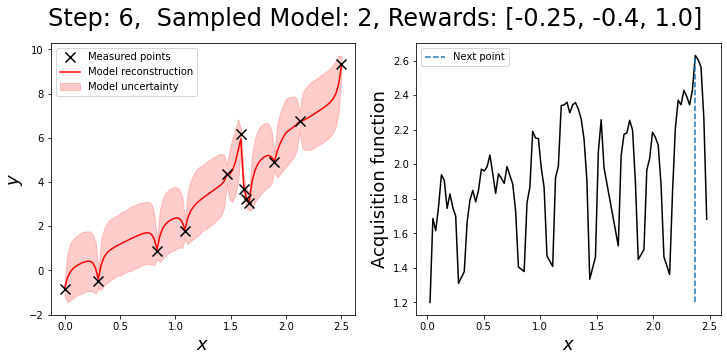

Exploration step 10/15
Using model 1


sample: 100%|██████████| 4000/4000 [01:29<00:00, 44.48it/s, 1023 steps of size 5.95e-05. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      4.12      0.12      4.13      3.92      4.29      6.00      1.48
         c      2.94      0.07      2.95      2.82      3.04      3.22      2.12
  k_length      0.14      0.02      0.14      0.11      0.17      9.72      1.02
   k_scale      1.40      0.17      1.45      1.14      1.60      2.71      2.33
     noise      0.09      0.01      0.09      0.07      0.10      5.96      1.10
         t      1.60      0.01      1.60      1.59      1.61    131.61      1.00



sample: 100%|██████████| 4000/4000 [01:13<00:00, 54.33it/s, 1023 steps of size 4.22e-03. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      4.33      0.23      4.36      4.00      4.68    231.99      1.00
         c      2.99      0.45      3.03      2.31      3.71    239.48      1.01
  k_length      0.52      0.20      0.51      0.18      0.85    381.58      1.00
   k_scale      1.94      1.43      1.52      0.44      3.76    257.30      1.00
     noise      0.09      0.05      0.08      0.02      0.16    737.37      1.00
         t      1.60      0.01      1.60      1.59      1.62    504.68      1.00



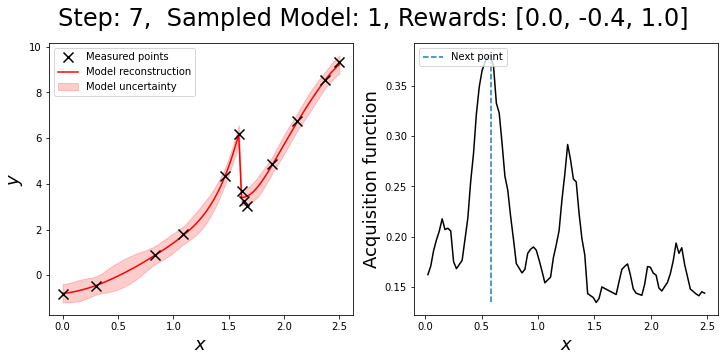

Exploration step 11/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:20<00:00, 49.68it/s, 1023 steps of size 4.95e-03. acc. prob=0.72]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.85      0.13      3.85      3.65      4.09    510.53      1.00
     beta2      2.42      0.10      2.43      2.27      2.58    400.47      1.00
  k_length      0.67      0.22      0.70      0.38      1.00    668.72      1.00
   k_scale      0.62      0.50      0.48      0.08      1.23    566.38      1.00
     noise      0.09      0.04      0.08      0.03      0.15    613.81      1.00
         t      1.60      0.01      1.60      1.59      1.61    447.98      1.00



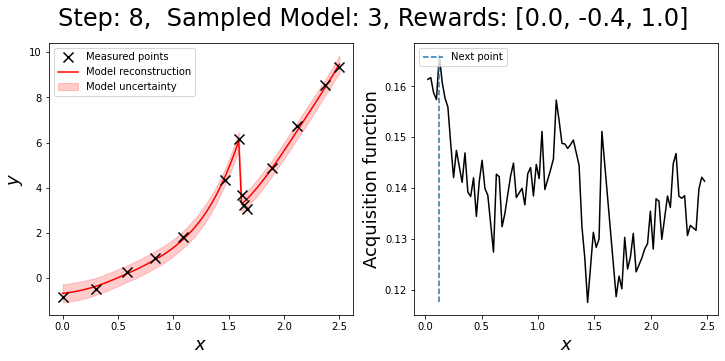

Exploration step 12/15
Using model 2


sample: 100%|██████████| 4000/4000 [01:50<00:00, 36.26it/s, 1023 steps of size 1.69e-03. acc. prob=0.78]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.22      0.68      2.25      0.90      3.07    182.63      1.00
         c      3.23      0.30      3.22      2.77      3.77     89.34      1.04
  k_length      0.03      0.03      0.03      0.00      0.06    255.18      1.00
   k_scale      1.48      0.68      1.33      0.47      2.35    209.18      1.00
     noise      0.10      0.07      0.09      0.00      0.18    113.55      1.00
         t      1.43      0.42      1.40      0.84      2.00    128.22      1.03



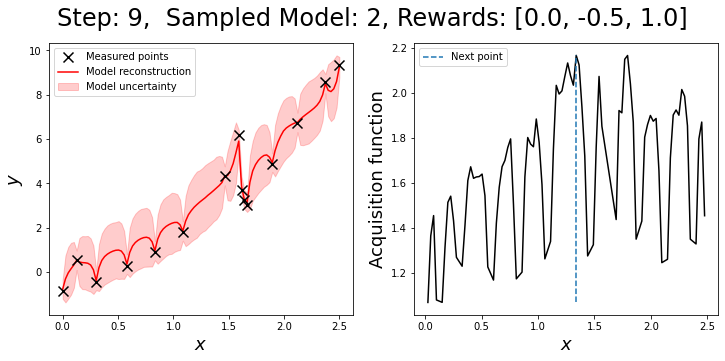

Exploration step 13/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:31<00:00, 43.78it/s, 895 steps of size 3.67e-03. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.81      0.16      3.82      3.57      4.09    496.67      1.01
     beta2      2.45      0.07      2.46      2.34      2.55    500.79      1.00
  k_length      0.38      0.34      0.29      0.00      0.90    182.47      1.00
   k_scale      0.33      0.27      0.25      0.04      0.61    471.49      1.00
     noise      0.11      0.06      0.11      0.00      0.19    225.02      1.00
         t      1.60      0.01      1.60      1.59      1.61    515.52      1.00



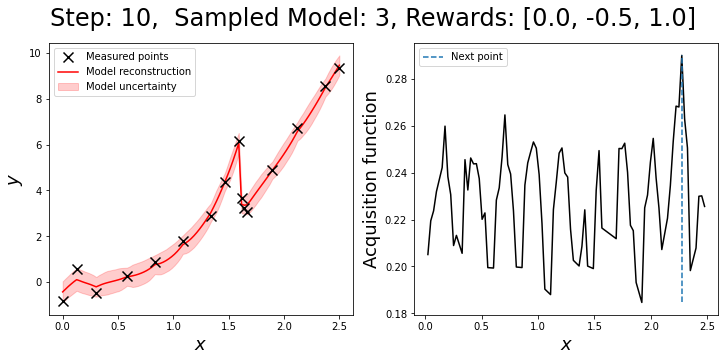

Exploration step 14/15
Using model 2


sample: 100%|██████████| 4000/4000 [01:46<00:00, 37.66it/s, 1023 steps of size 1.44e-03. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      4.36      0.50      4.38      3.52      5.16    200.66      1.01
         c      2.78      0.49      2.81      1.94      3.55    179.71      1.01
  k_length      0.74      0.18      0.76      0.47      1.00    244.25      1.00
   k_scale      3.03      1.75      2.57      0.78      5.37    257.03      1.00
     noise      0.17      0.05      0.16      0.08      0.24    239.91      1.01
         t      1.60      0.01      1.60      1.59      1.62    198.36      1.00



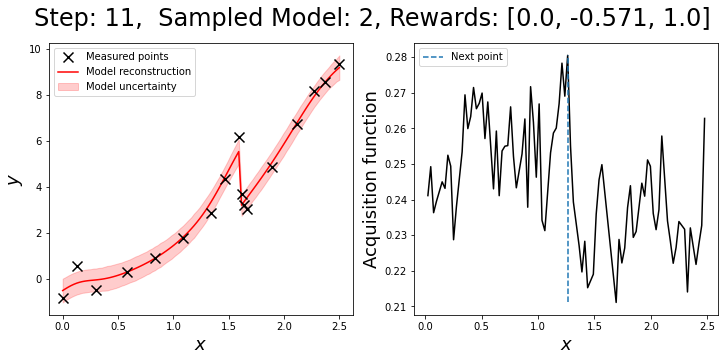

Exploration step 15/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:50<00:00, 36.09it/s, 1023 steps of size 4.49e-03. acc. prob=0.72]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.80      0.17      3.80      3.55      4.06    420.02      1.01
     beta2      2.46      0.07      2.47      2.35      2.56    233.58      1.00
  k_length      0.31      0.32      0.13      0.00      0.86    188.38      1.02
   k_scale      0.36      0.35      0.27      0.04      0.70    441.25      1.00
     noise      0.10      0.07      0.10      0.00      0.19    216.00      1.01
         t      1.60      0.01      1.60      1.59      1.61    578.20      1.00



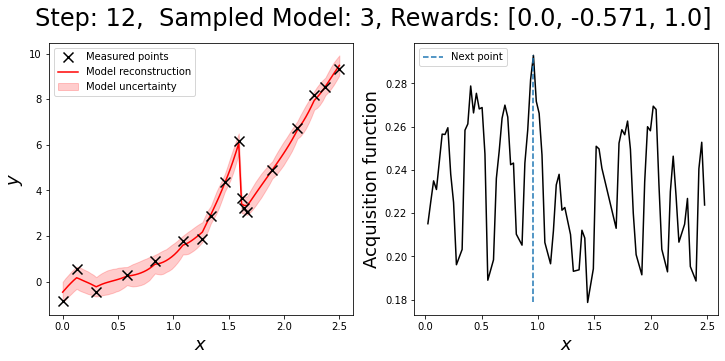

In [ ]:
exploration_steps = 15
eps = 0.4
warmup_steps = 3

models = [piecewise1, piecewise2, piecewise3]
model_priors = [piecewise1_priors, piecewise2_priors, piecewise3_priors]
save_reconstruction = True  # available only for exploration phase

onp.random.seed(55)  # rng seed for epsilon-greedy sampling
record = onp.zeros((len(models), 2))
model_choices = []
obj_history = []

# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []
    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):
        # for each model, run BI and store uncertainty values
        obj, _ = step(model, model_priors[i], X_train, y_train, X_test)
        record[i, 0] += 1
        obj_all.append(obj)
        obj_median_all.append(jnp.nanmedian(obj).item())  # (one can use integral uncertainty instead of median)
    # 'Reward' a model that has the smallest integral/median uncertainty
    idx = onp.argmin(obj_median_all)
    model_choices.append(idx)
    record[idx, 1] += 1
    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])
    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Evaluate the function in the suggested point
    measured_point = y_test[next_point_idx]
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))
    
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))
    # Choose model according to epsilon-greedy policy
    if onp.random.random() > eps: 
        idx = get_best_model(record)
    else:
        idx = onp.random.randint(len(models))
    model_choices.append(idx)
    print("Using model {}".format(idx+1))
    # Derive acqusition function with the selected model
    obj, m_post = step(models[idx], model_priors[idx], X_train, y_train, X_test, num_restarts=2)
    # Get reward
    r = get_reward(obj_history, obj)
    # Update records
    record = update_record(record, idx, r)
    obj_history.append(jnp.nanmedian(obj).item())
    # Evaluate function in the suggested point
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    measured_point = y_test[next_point_idx]
    if save_reconstruction:    
        # plot current reconstruction and acqusition function
        y_pred, y_sampled = m_post.predict(gpax.utils.get_keys()[1], X)
        plot_results(X_train, y_train, X_test, y_pred, y_sampled.squeeze(), obj, idx+1, record[:, 1],  e=e)
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))

Plot integral/median uncerainty as a function of exploration steps:

(note that for the warm-up steps, we plot only model that produced lowest uncertainty)

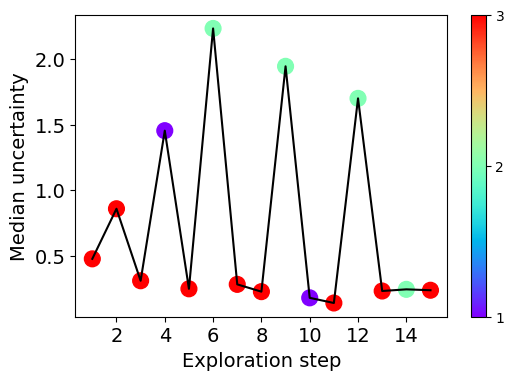

In [ ]:
plt.figure(dpi=100)
plt.plot(onp.arange(1, exploration_steps+1), obj_history, c='k')
plt.scatter(onp.arange(1, exploration_steps+1), obj_history,
            c=[m+1 for m in model_choices],
            s=128, cmap='rainbow', alpha=1)
plt.xlabel("Exploration step", fontsize=14)
plt.ylabel("Median uncertainty", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3])

View average reward associated with each model:

(note that it counts the warmup steps where all the models were evaluated)

In [ ]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), onp.round(r[1], 3)))

model 1:  counts 5  reward (avg) 0.0
model 2:  counts 7  reward (avg) -0.571
model 3:  counts 9  reward (avg) 1.0


Compute (and plot) each model's prediction over the entire grid using the final set of the discovered point:


sample: 100%|██████████| 4000/4000 [02:08<00:00, 31.05it/s, 1023 steps of size 4.31e-04. acc. prob=0.97]



 Model 1, Reward (avg) 0.0


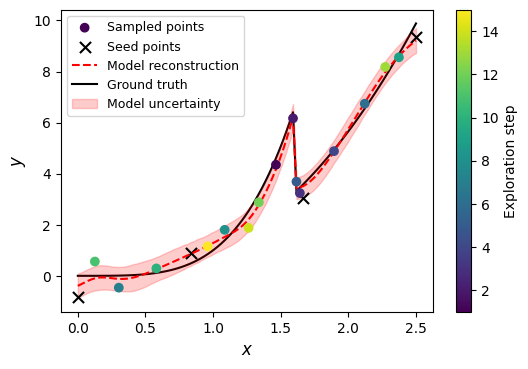

sample: 100%|██████████| 4000/4000 [02:08<00:00, 31.20it/s, 1023 steps of size 2.52e-04. acc. prob=0.93]



 Model 2, Reward (avg) -0.571


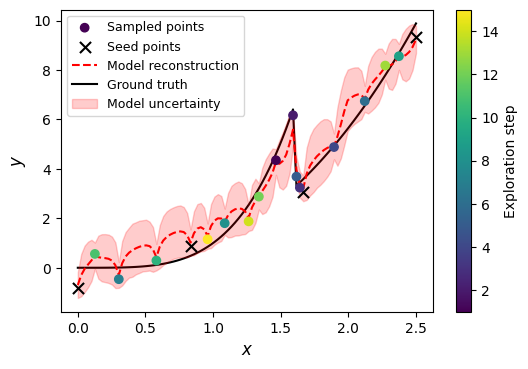

sample: 100%|██████████| 4000/4000 [02:00<00:00, 33.18it/s, 1023 steps of size 3.63e-03. acc. prob=0.75]



 Model 3, Reward (avg) 1.0


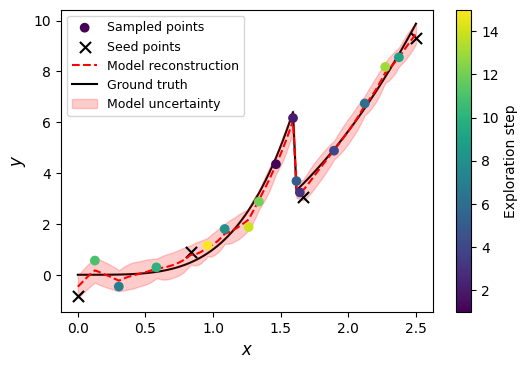

In [ ]:
for i, model in enumerate(models):
    # same as in the main loop, we use restarts to help avoiding bad initialization
    _, gp_model = step(model, model_priors[i], X_train, y_train, num_restarts=2, print_summary=0)
    y_pred, y_sampled = gp_model.predict(gpax.utils.get_keys()[1], X)
    print("\n Model {}, Reward (avg) {}".format(i+1, onp.round(record[i, 1], 3)))
    plot_final_result(X_train, y_train, X, y_pred, y_sampled.squeeze(), seed_points=num_seed_points)

We see that the model which received the highest reward (i.e., is
favored by our algorithm) clearly provided the best fit. Hence, we were able both to learn a correct data distribution with a small number of sparse measurements while also identifying a correct model that describes the system’s behavior.